# 영화 임베딩 버전별 성능 비교

## 버전 설명

| 버전 | 방법 | 설명 |
|------|------|------|
| `full` | CARTE | 전체 피처 (actor, director, genre 등) |
| `full_bert` | CARTE | 전체 피처 + BERT (tagline, overview) |
| `no_person` | CARTE | 인물 피처 제외 |
| `no_person_bert` | CARTE | 인물 피처 제외 + BERT |
| `kg_gnn` | Knowledge Graph GNN | 영화-엔티티 그래프 기반 |

## 사용된 피처

| 버전 | actor | director | writer | genre | company | country | language | year | BERT (tagline, overview) |
|------|:-----:|:--------:|:------:|:-----:|:-------:|:-------:|:--------:|:----:|:------------------------:|
| `full` | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ | - |
| `full_bert` | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ |
| `no_person` | - | - | - | ✓ | ✓ | ✓ | ✓ | ✓ | - |
| `no_person_bert` | - | - | - | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ |
| `kg_gnn` | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ | ✓ | - |

## 임베딩 방법론

### CARTE (Context-Aware Representations for Tables via Embedding)
- 각 영화를 독립적인 graphlet으로 변환 (컬럼 = 노드)
- 텍스트 값은 fastText로 임베딩, 수치 값은 그대로 사용
- 사전학습된 GNN으로 message passing 후 head node 임베딩 추출
- **특징**: 같은 배우가 등장해도 영화 간 직접 연결 없음 (같은 fastText 벡터만 공유)

### Knowledge Graph GNN
- 영화-엔티티 이종 그래프 구축 (영화 ↔ 배우/감독/장르 등)
- **특징**: 같은 엔티티를 공유하는 영화들이 그래프 상에서 연결됨
- HeteroConv (SAGEConv) 기반 2-layer GNN
- Link Prediction (BPR Loss)로 비지도 학습

In [319]:
import sys
sys.path.insert(0, "/Users/jisoo/projects/thesis/carte_test")

import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pathlib import Path

from config import PROCESSED

# 한글 폰트
if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
elif platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

## 1. 데이터 로드

In [320]:
# 카탈로그
catalog = pd.read_parquet(PROCESSED.MOVIE_CATALOG_PARQUET)
ratings = pd.read_parquet(PROCESSED.RATINGS_PARQUET)
movie_ids_in_ratings = ratings['movieId'].unique()
catalog_filtered = catalog[catalog['movieId'].isin(movie_ids_in_ratings)].reset_index(drop=True)
print(f"영화 수: {len(catalog_filtered):,}")

영화 수: 53,630


In [321]:
# 임베딩 로드
EMBEDDINGS_DIR = PROCESSED.DIR / "ablation_embeddings"
VERSION_NAMES = ['full', 'full_bert', 'no_person', 'no_person_bert', 'kg_gnn']

embeddings = {}
print("임베딩 로드:")
for name in VERSION_NAMES:
    path = EMBEDDINGS_DIR / f"emb_{name}.parquet"
    if path.exists():
        df = pd.read_parquet(path)
        embeddings[name] = {
            'ids': df['movieId'].to_numpy(),
            'emb': np.array(df['embedding'].tolist(), dtype=np.float32)
        }
        print(f"  {name}: {embeddings[name]['emb'].shape}")
    else:
        print(f"  {name}: 파일 없음 (skip)")

VERSIONS = list(embeddings.keys())
print(f"\n비교 대상: {VERSIONS}")

임베딩 로드:
  full: (53630, 300)
  full_bert: (53630, 300)
  no_person: (53630, 300)
  no_person_bert: (53630, 300)
  kg_gnn: (53630, 300)

비교 대상: ['full', 'full_bert', 'no_person', 'no_person_bert', 'kg_gnn']


In [322]:
# 정규화
def normalize(emb):
    norms = np.linalg.norm(emb, axis=1, keepdims=True)
    return emb / (norms + 1e-12)

emb_norm = {v: normalize(embeddings[v]['emb']) for v in VERSIONS}

## 2. 임베딩 품질 통계

In [323]:
def compute_stats(emb):
    """품질 통계 계산"""
    # NaN 제거
    nan_mask = np.isnan(emb).any(axis=1)
    emb = emb[~nan_mask]
    
    # 정규화
    norms = np.linalg.norm(emb, axis=1)
    valid = norms > 1e-10
    emb_n = emb[valid] / norms[valid, None]
    
    # Anisotropy
    aniso = np.linalg.norm(emb_n.mean(axis=0))
    
    # Random pair cosine
    rng = np.random.default_rng(42)
    n = len(emb_n)
    i1, i2 = rng.integers(0, n, 50000), rng.integers(0, n, 50000)
    i2[i1 == i2] = (i2[i1 == i2] + 1) % n
    cos = (emb_n[i1] * emb_n[i2]).sum(axis=1)
    
    return {
        'anisotropy': aniso,
        'cos_mean': cos.mean(),
        'cos_std': cos.std(),
        'cos_p5': np.percentile(cos, 5),
        'cos_p95': np.percentile(cos, 95),
    }

# 통계 계산
stats = {v: compute_stats(embeddings[v]['emb']) for v in VERSIONS}
stats_df = pd.DataFrame(stats).T
stats_df

,anisotropy,cos_mean,cos_std,cos_p5,cos_p95
full,0.977459,0.956013,0.055799,0.866842,0.995555
full_bert,0.972107,0.945147,0.066285,0.833085,0.993937
no_person,0.924337,0.853707,0.198553,0.462873,0.995283
no_person_bert,0.894218,0.800678,0.249589,0.234540,0.989205
kg_gnn,0.699108,0.490192,0.299370,0.026947,0.937059


In [324]:
# 주요 지표 출력
print("[임베딩 품질 비교]")
print("="*85)
print(f"{'Version':<18} {'Anisotropy':>12} {'Cos Mean':>12} {'Cos Std':>12} {'Cos p95':>12}")
print("-"*85)
for v in VERSIONS:
    s = stats[v]
    print(f"{v:<18} {s['anisotropy']:>12.4f} {s['cos_mean']:>12.4f} {s['cos_std']:>12.4f} {s['cos_p95']:>12.4f}")
print("="*85)
print("* Anisotropy, Cos Mean: 낮을수록 좋음 (임베딩 공간 활용도 높음)")

[임베딩 품질 비교]
Version              Anisotropy     Cos Mean      Cos Std      Cos p95
-------------------------------------------------------------------------------------
full                     0.9775       0.9560       0.0558       0.9956
full_bert                0.9721       0.9451       0.0663       0.9939
no_person                0.9243       0.8537       0.1986       0.9953
no_person_bert           0.8942       0.8007       0.2496       0.9892
kg_gnn                   0.6991       0.4902       0.2994       0.9371
* Anisotropy, Cos Mean: 낮을수록 좋음 (임베딩 공간 활용도 높음)


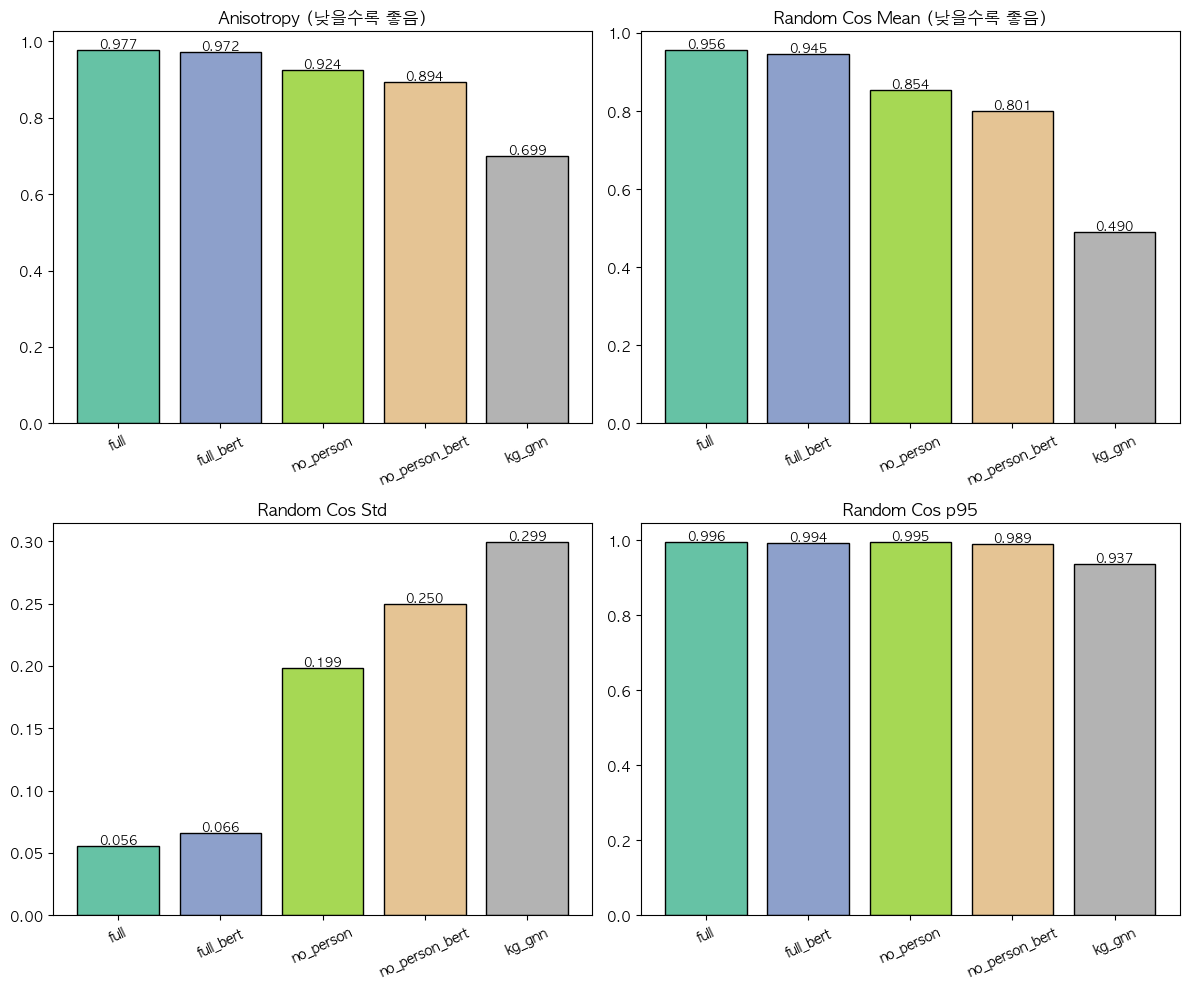

In [325]:
# 시각화
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
metrics = ['anisotropy', 'cos_mean', 'cos_std', 'cos_p95']
titles = ['Anisotropy (낮을수록 좋음)', 'Random Cos Mean (낮을수록 좋음)', 'Random Cos Std', 'Random Cos p95']
colors = plt.cm.Set2(np.linspace(0, 1, len(VERSIONS)))

for ax, metric, title in zip(axes.flat, metrics, titles):
    vals = [stats[v][metric] for v in VERSIONS]
    bars = ax.bar(VERSIONS, vals, color=colors, edgecolor='black')
    ax.set_title(title, fontweight='bold')
    ax.tick_params(axis='x', rotation=25)
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 3. PCA 시각화

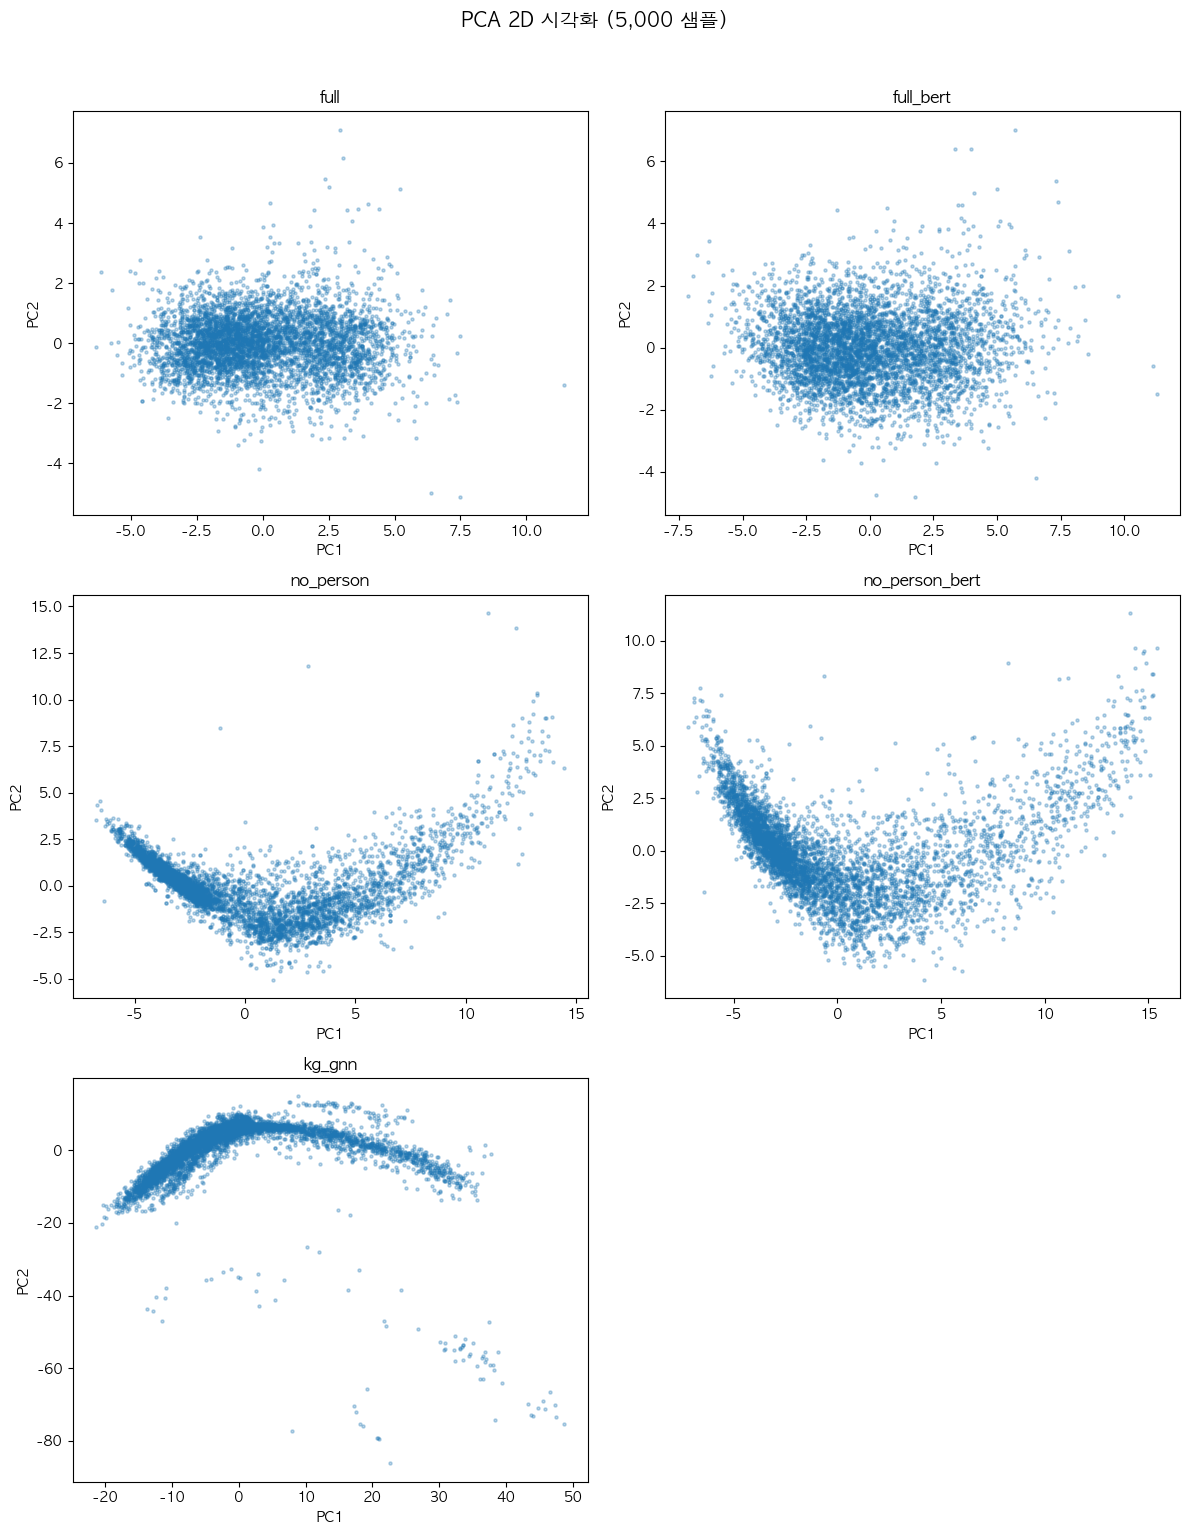

In [326]:
# 샘플링
n_sample = min(5000, len(embeddings[VERSIONS[0]]['emb']))
rng = np.random.default_rng(42)
sample_idx = rng.choice(len(embeddings[VERSIONS[0]]['emb']), n_sample, replace=False)

# PCA (2열 배치)
ncols = 2
nrows = (len(VERSIONS) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))
axes = axes.flat

for i, v in enumerate(VERSIONS):
    emb = embeddings[v]['emb'][sample_idx]
    valid = ~np.isnan(emb).any(axis=1)
    pca = PCA(n_components=2).fit_transform(emb[valid])
    axes[i].scatter(pca[:, 0], pca[:, 1], alpha=0.3, s=5)
    axes[i].set_title(v, fontweight='bold', fontsize=12)
    axes[i].set_xlabel('PC1')
    axes[i].set_ylabel('PC2')

for i in range(len(VERSIONS), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('PCA 2D 시각화 (5,000 샘플)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 4. 케이스 스터디

In [327]:
# 유틸리티 함수
def sim_matrix(movie_ids, version):
    """유사도 행렬 계산"""
    ids = embeddings[version]['ids']
    emb = emb_norm[version]
    n = len(movie_ids)
    sim = np.full((n, n), np.nan)
    for i, mi in enumerate(movie_ids):
        for j, mj in enumerate(movie_ids):
            idx_i = np.where(ids == mi)[0]
            idx_j = np.where(ids == mj)[0]
            if len(idx_i) > 0 and len(idx_j) > 0:
                sim[i, j] = emb[idx_i[0]] @ emb[idx_j[0]]
    return sim

def mean_sim(sim):
    """대각선 제외 평균"""
    n = sim.shape[0]
    vals = [sim[i, j] for i in range(n) for j in range(n) if i != j]
    return np.nanmean(vals)

def short_title(mid, prefix=None):
    """영화 제목 축약"""
    row = catalog_filtered[catalog_filtered['movieId'] == mid]
    if len(row) == 0:
        return f"ID:{mid}"
    t = row['original_title'].values[0]
    if prefix:
        for p in prefix:
            t = t.replace(p, '')
    return t.strip()[:18]

In [328]:
# 케이스 정의
CASES = {
    '반지의제왕/호빗': {
        'ids': [4993, 5952, 7153, 98809, 106489, 118696],
        'prefix': ['The Lord of the Rings: The ', 'The Hobbit: '],
        'boundary': 3,
    },
    '해리포터': {
        'ids': [4896, 5816, 8368, 40815, 54001, 69844, 81834, 88125],
        'prefix': ['Harry Potter and the ', 'Harry Potter and The '],
    },
    '놀란 감독': {
        'ids': catalog_filtered[catalog_filtered['director_1'] == 'Christopher Nolan']['movieId'].tolist(),
    },
    '픽사': {
        'ids': catalog_filtered[catalog_filtered['produced_by_company_1'] == 'Pixar']['movieId'].tolist(),
    },
}

print("[케이스 스터디]")
for name, info in CASES.items():
    print(f"  {name}: {len(info['ids'])}편")

[케이스 스터디]
  반지의제왕/호빗: 6편
  해리포터: 8편
  놀란 감독: 12편
  픽사: 72편


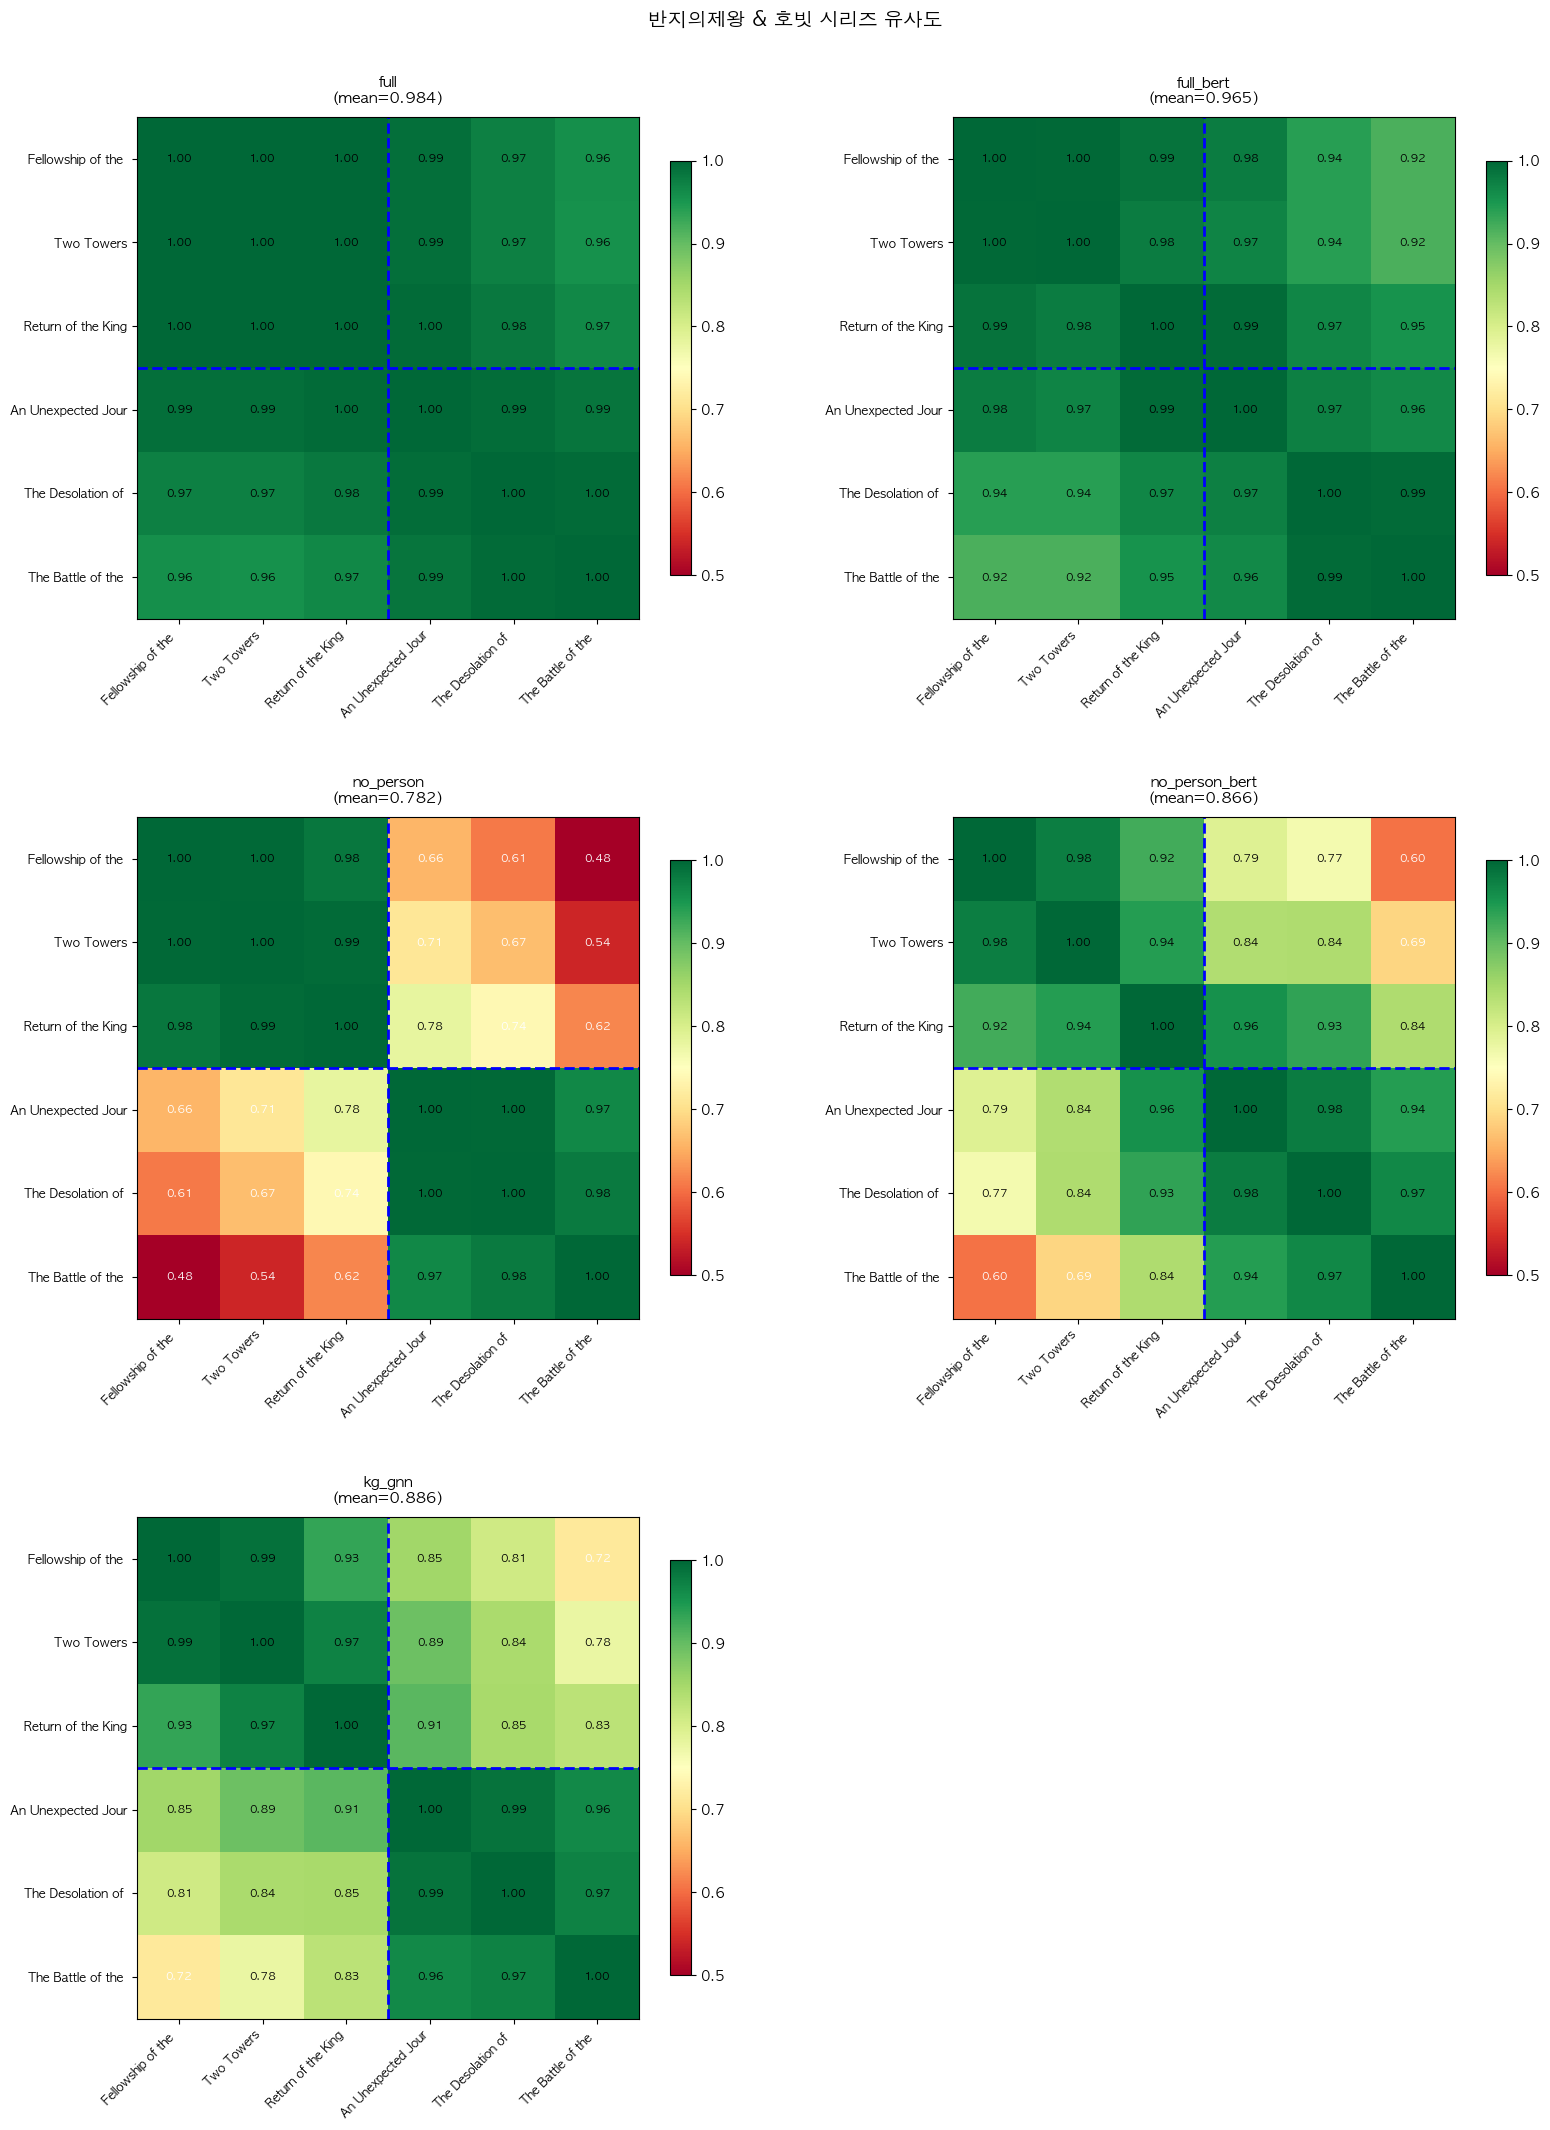

In [329]:
# 반지의제왕/호빗 히트맵 (2열 배치, 레이블 겹침 해결)
case = CASES['반지의제왕/호빗']
ids = case['ids']
titles = [short_title(m, case.get('prefix')) for m in ids]

ncols = 2
nrows = (len(VERSIONS) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(8*ncols, 7*nrows))
axes = axes.flat

for i, v in enumerate(VERSIONS):
    sim = sim_matrix(ids, v)
    im = axes[i].imshow(sim, cmap='RdYlGn', vmin=0.5, vmax=1.0)
    axes[i].set_xticks(range(len(titles)))
    axes[i].set_yticks(range(len(titles)))
    axes[i].set_xticklabels(titles, rotation=45, ha='right', fontsize=9)
    axes[i].set_yticklabels(titles, fontsize=9)
    axes[i].set_title(f'{v}\n(mean={mean_sim(sim):.3f})', fontweight='bold', fontsize=11, pad=10)
    
    for x in range(len(titles)):
        for y in range(len(titles)):
            if not np.isnan(sim[x, y]):
                c = 'white' if sim[x, y] < 0.75 else 'black'
                axes[i].text(y, x, f'{sim[x,y]:.2f}', ha='center', va='center', color=c, fontsize=8)
    
    if 'boundary' in case:
        b = case['boundary'] - 0.5
        axes[i].axhline(y=b, color='blue', lw=2, ls='--')
        axes[i].axvline(x=b, color='blue', lw=2, ls='--')
    
    # 컬러바
    plt.colorbar(im, ax=axes[i], shrink=0.8)

for i in range(len(VERSIONS), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('반지의제왕 & 호빗 시리즈 유사도', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.subplots_adjust(hspace=0.35, wspace=0.3)
plt.show()

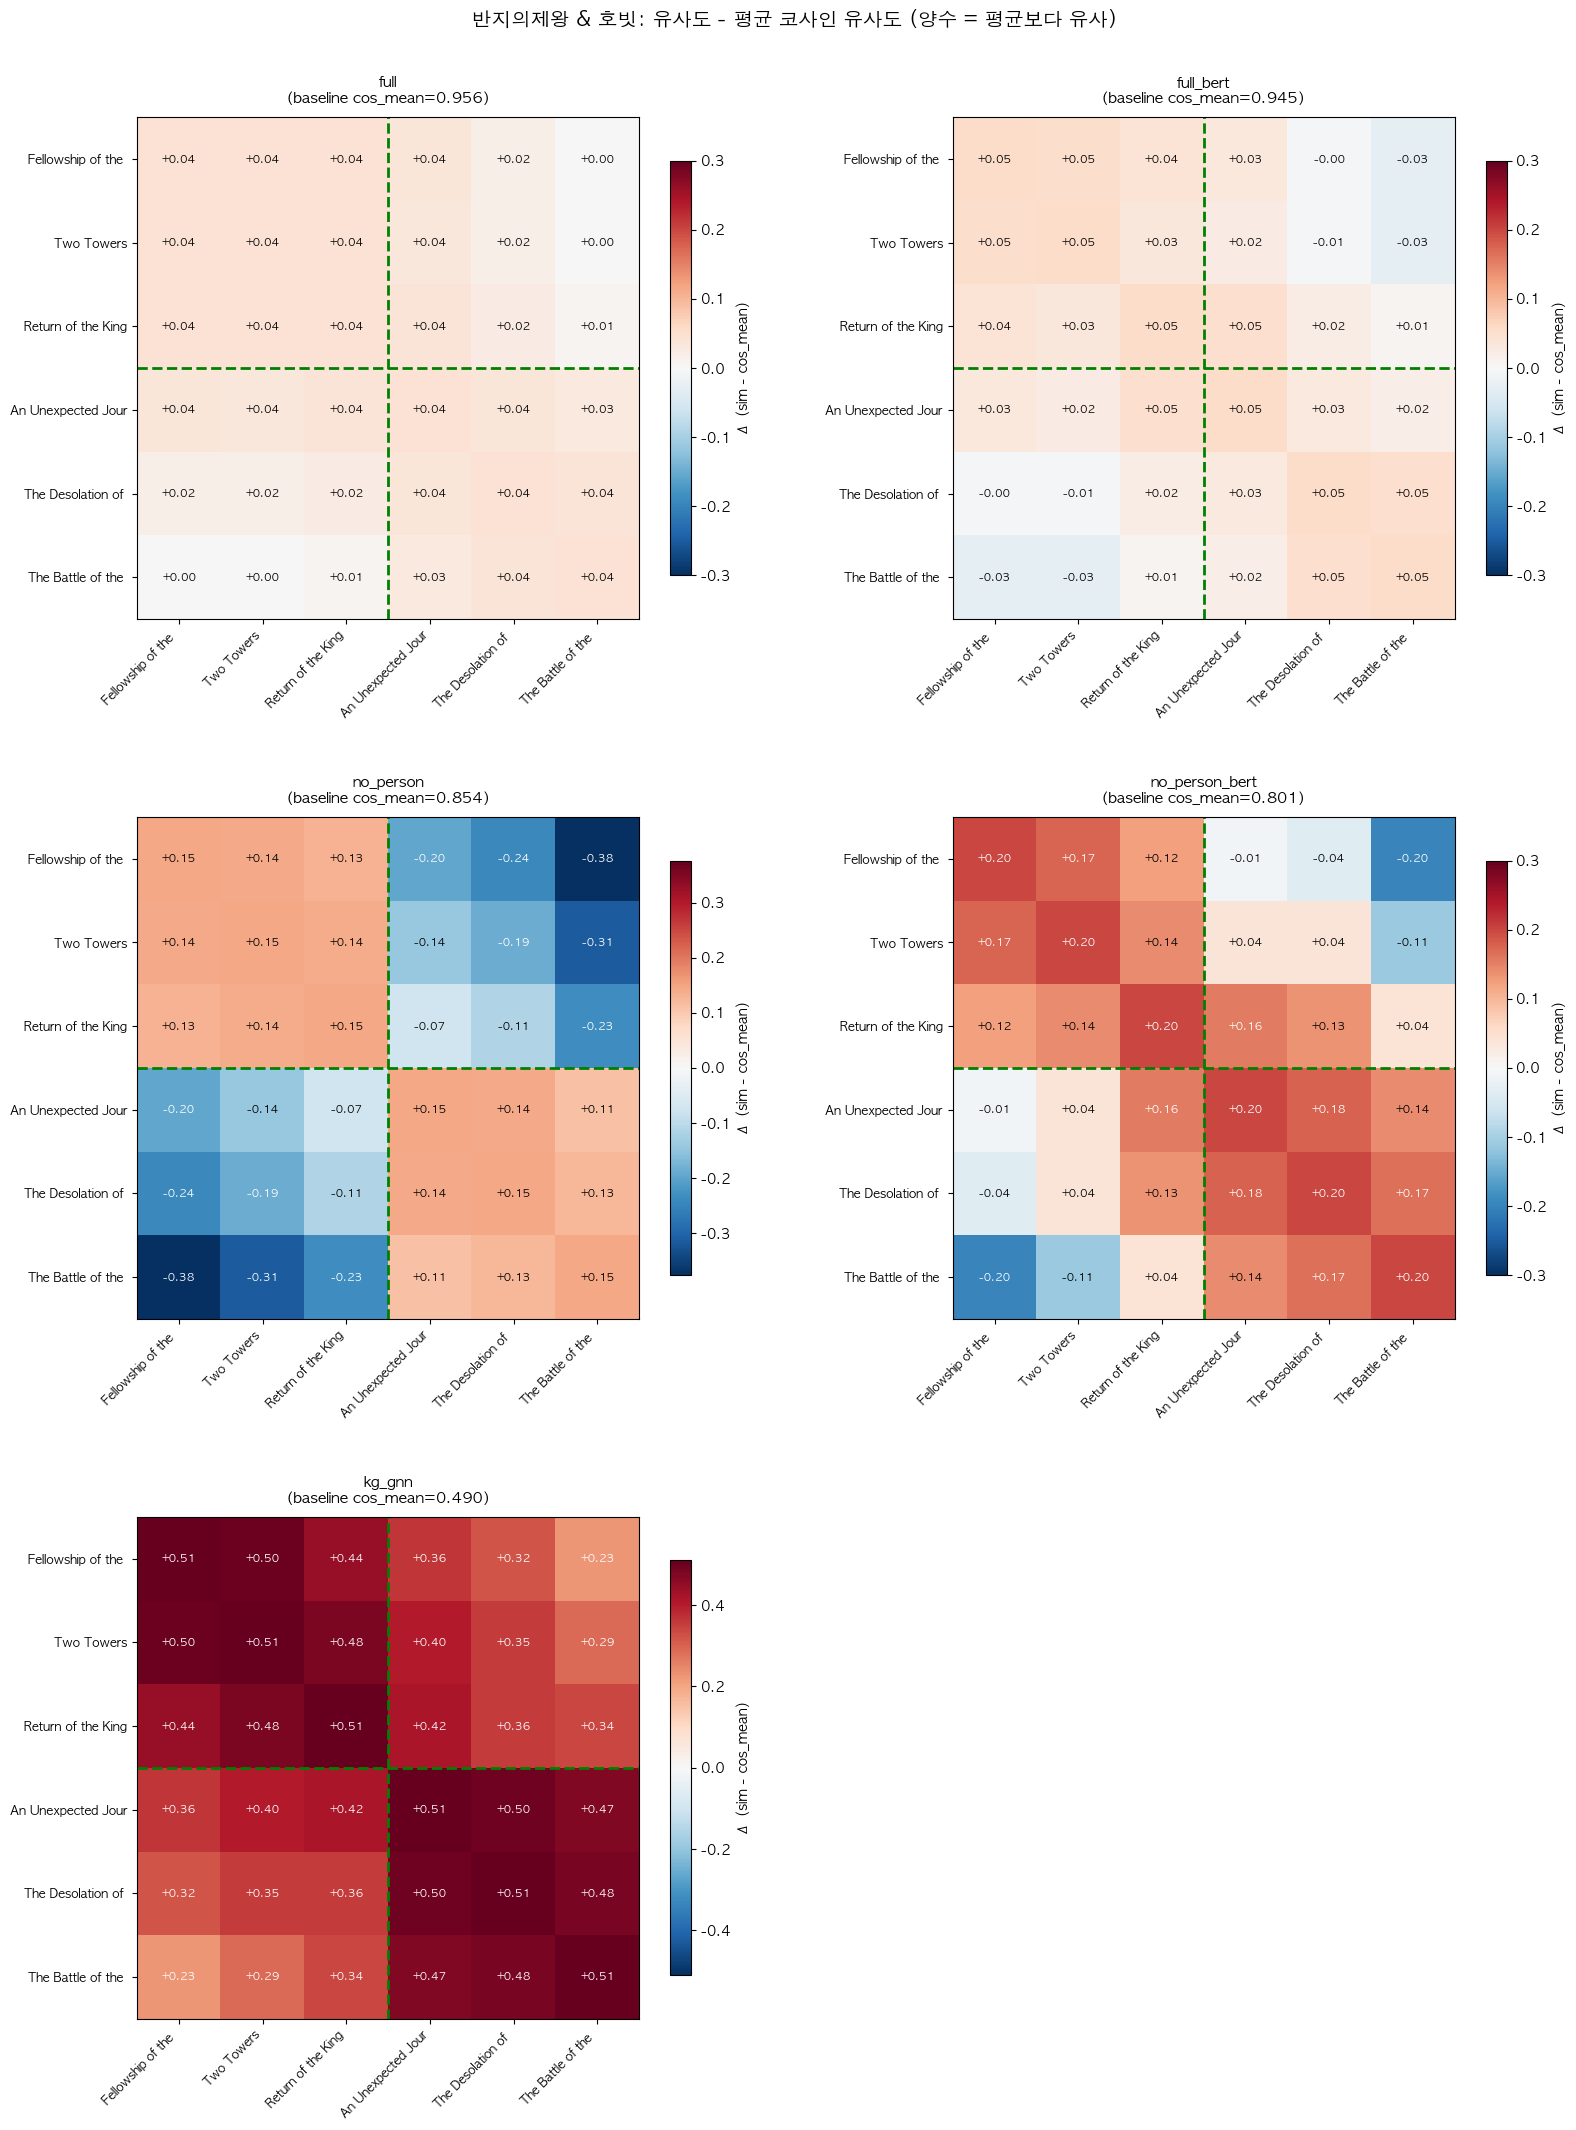

In [330]:
# 유사도 차이 히트맵: (유사도 - 평균 코사인 유사도)
# 평균 대비 얼마나 더 유사한지 시각화

case = CASES['반지의제왕/호빗']
ids = case['ids']
titles = [short_title(m, case.get('prefix')) for m in ids]

ncols = 2
nrows = (len(VERSIONS) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(8*ncols, 7*nrows))
axes = axes.flat

for i, v in enumerate(VERSIONS):
    sim = sim_matrix(ids, v)
    cos_mean = stats[v]['cos_mean']
    diff = sim - cos_mean  # 평균 대비 차이
    
    # 차이값 범위에 맞게 색상 범위 설정 (음수~양수)
    vmax = max(0.3, np.nanmax(np.abs(diff)))
    im = axes[i].imshow(diff, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    axes[i].set_xticks(range(len(titles)))
    axes[i].set_yticks(range(len(titles)))
    axes[i].set_xticklabels(titles, rotation=45, ha='right', fontsize=9)
    axes[i].set_yticklabels(titles, fontsize=9)
    axes[i].set_title(f'{v}\n(baseline cos_mean={cos_mean:.3f})', fontweight='bold', fontsize=11, pad=10)
    
    for x in range(len(titles)):
        for y in range(len(titles)):
            if not np.isnan(diff[x, y]):
                val = diff[x, y]
                c = 'white' if abs(val) > 0.15 else 'black'
                sign = '+' if val >= 0 else ''
                axes[i].text(y, x, f'{sign}{val:.2f}', ha='center', va='center', color=c, fontsize=8)
    
    if 'boundary' in case:
        b = case['boundary'] - 0.5
        axes[i].axhline(y=b, color='green', lw=2, ls='--')
        axes[i].axvline(x=b, color='green', lw=2, ls='--')
    
    plt.colorbar(im, ax=axes[i], shrink=0.8, label='Δ (sim - cos_mean)')

for i in range(len(VERSIONS), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('반지의제왕 & 호빗: 유사도 - 평균 코사인 유사도 (양수 = 평균보다 유사)', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.subplots_adjust(hspace=0.35, wspace=0.3)
plt.show()

In [331]:
# 전체 케이스 비교
print("\n[케이스 스터디: 시리즈 내 평균 유사도]")
print("="*100)

header = f"{'케이스':<14}"
for v in VERSIONS:
    header += f"{v:>16}"
print(header)
print("-"*100)

for case_name, case_info in CASES.items():
    row = f"{case_name:<14}"
    for v in VERSIONS:
        sim = sim_matrix(case_info['ids'], v)
        row += f"{mean_sim(sim):>16.4f}"
    print(row)


[케이스 스터디: 시리즈 내 평균 유사도]
케이스                       full       full_bert       no_person  no_person_bert          kg_gnn
----------------------------------------------------------------------------------------------------
반지의제왕/호빗                0.9838          0.9650          0.7816          0.8659          0.8862
해리포터                    0.9937          0.9808          0.8360          0.7150          0.8887
놀란 감독                   0.9769          0.9707          0.8176          0.7840          0.7371
픽사                      0.9745          0.9504          0.8726          0.8217          0.6381


In [332]:
# 유의미성 판단 (시리즈 유사도 > 평균 코사인 유사도)
print("\n[유의미성: 시리즈 유사도 > 평균 코사인 유사도]")
print("="*115)

header = f"{'Version':<16} {'Cos Mean':>10}"
for case_name in CASES:
    header += f"{case_name:>18}"
print(header)
print("-"*115)

for v in VERSIONS:
    cos_mean = stats[v]['cos_mean']
    row = f"{v:<16} {cos_mean:>10.4f}"
    for case_name, case_info in CASES.items():
        sim = sim_matrix(case_info['ids'], v)
        ms = mean_sim(sim)
        diff = ms - cos_mean
        sig = '✓' if ms > cos_mean else '✗'
        row += f"{ms:>10.3f} (+{diff:.2f}) {sig:>2}"
    print(row)

print("-"*115)
print("* ✓: 시리즈 내 평균 유사도가 전체 평균 코사인 유사도보다 높음")


[유의미성: 시리즈 유사도 > 평균 코사인 유사도]
Version            Cos Mean          반지의제왕/호빗              해리포터             놀란 감독                픽사
-------------------------------------------------------------------------------------------------------------------
full                 0.9560     0.984 (+0.03)  ✓     0.994 (+0.04)  ✓     0.977 (+0.02)  ✓     0.975 (+0.02)  ✓
full_bert            0.9451     0.965 (+0.02)  ✓     0.981 (+0.04)  ✓     0.971 (+0.03)  ✓     0.950 (+0.01)  ✓
no_person            0.8537     0.782 (+-0.07)  ✗     0.836 (+-0.02)  ✗     0.818 (+-0.04)  ✗     0.873 (+0.02)  ✓
no_person_bert       0.8007     0.866 (+0.07)  ✓     0.715 (+-0.09)  ✗     0.784 (+-0.02)  ✗     0.822 (+0.02)  ✓
kg_gnn               0.4902     0.886 (+0.40)  ✓     0.889 (+0.40)  ✓     0.737 (+0.25)  ✓     0.638 (+0.15)  ✓
-------------------------------------------------------------------------------------------------------------------
* ✓: 시리즈 내 평균 유사도가 전체 평균 코사인 유사도보다 높음


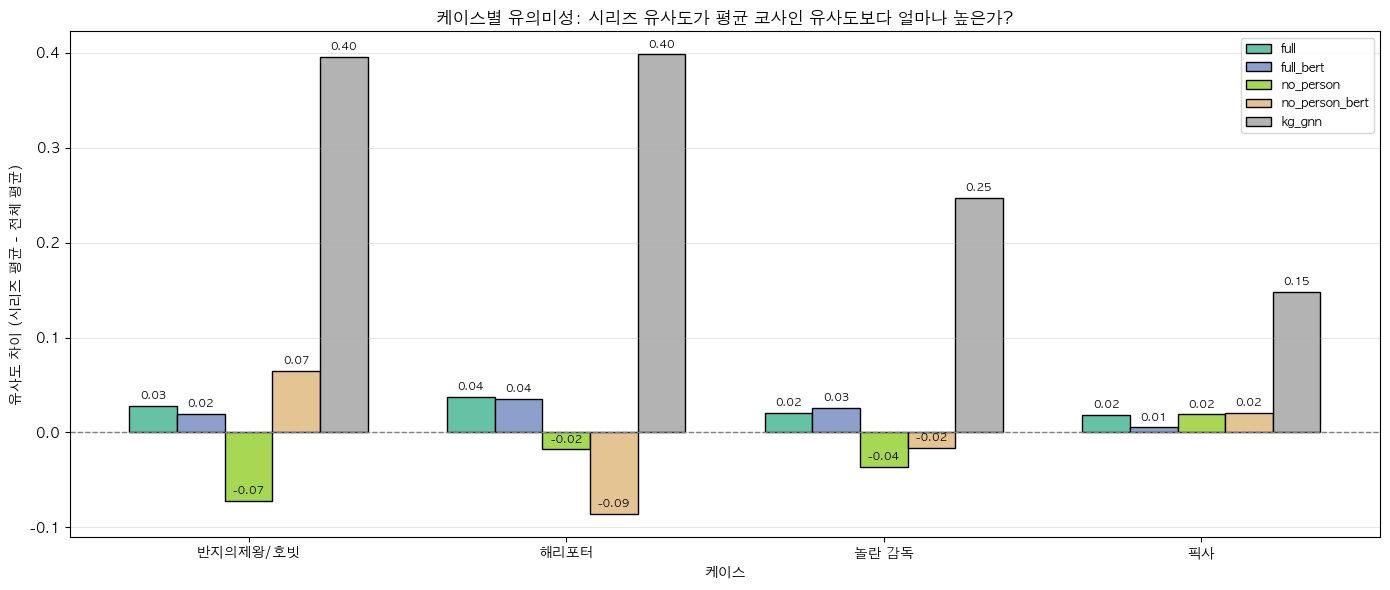

In [333]:
# 케이스별 유사도 차이 바 차트 (시리즈 유사도 - 평균 코사인 유사도)
case_names = list(CASES.keys())
n_cases = len(case_names)
n_versions = len(VERSIONS)

# 차이값 계산
diff_data = {}
for case_name, case_info in CASES.items():
    diff_data[case_name] = {}
    for v in VERSIONS:
        sim = sim_matrix(case_info['ids'], v)
        ms = mean_sim(sim)
        cos_mean = stats[v]['cos_mean']
        diff_data[case_name][v] = ms - cos_mean

# 바 차트
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(n_cases)
width = 0.15
colors = plt.cm.Set2(np.linspace(0, 1, n_versions))

for i, v in enumerate(VERSIONS):
    vals = [diff_data[c][v] for c in case_names]
    bars = ax.bar(x + i*width, vals, width, label=v, color=colors[i], edgecolor='black')
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                f'{val:.2f}', ha='center', va='bottom', fontsize=8, rotation=0)

ax.axhline(y=0, color='gray', linestyle='--', lw=1)
ax.set_xlabel('케이스', fontweight='bold')
ax.set_ylabel('유사도 차이 (시리즈 평균 - 전체 평균)', fontweight='bold')
ax.set_title('케이스별 유의미성: 시리즈 유사도가 평균 코사인 유사도보다 얼마나 높은가?', fontweight='bold', fontsize=12)
ax.set_xticks(x + width * (n_versions - 1) / 2)
ax.set_xticklabels(case_names)
ax.legend(loc='upper right', fontsize=9)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. 최종 요약

In [334]:
print("="*100)
print("영화 임베딩 버전별 성능 비교 - 최종 요약")
print("="*100)

print(f"\n분석 영화 수: {len(catalog_filtered):,}")
print(f"비교 버전: {VERSIONS}")

print("\n[품질 지표]")
print(f"{'Version':<16} {'Anisotropy':>12} {'Cos Mean':>12} {'Cos p95':>12}")
print("-"*54)
for v in VERSIONS:
    s = stats[v]
    print(f"{v:<16} {s['anisotropy']:>12.4f} {s['cos_mean']:>12.4f} {s['cos_p95']:>12.4f}")

best_aniso = min(VERSIONS, key=lambda x: stats[x]['anisotropy'])
best_cos = min(VERSIONS, key=lambda x: stats[x]['cos_mean'])

print(f"\n[Best]")
print(f"  Anisotropy: {best_aniso} ({stats[best_aniso]['anisotropy']:.4f})")
print(f"  Cos Mean:   {best_cos} ({stats[best_cos]['cos_mean']:.4f})")

print("\n" + "="*100)

영화 임베딩 버전별 성능 비교 - 최종 요약

분석 영화 수: 53,630
비교 버전: ['full', 'full_bert', 'no_person', 'no_person_bert', 'kg_gnn']

[품질 지표]
Version            Anisotropy     Cos Mean      Cos p95
------------------------------------------------------
full                   0.9775       0.9560       0.9956
full_bert              0.9721       0.9451       0.9939
no_person              0.9243       0.8537       0.9953
no_person_bert         0.8942       0.8007       0.9892
kg_gnn                 0.6991       0.4902       0.9371

[Best]
  Anisotropy: kg_gnn (0.6991)
  Cos Mean:   kg_gnn (0.4902)

